# Content
1. ['Optimizing Portfolio Sharp'](#1)
- Given a list of tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META', 'TSLA', 'BRK-A', 'V', 'JNJ', 'WMT']

- Highest sharpe ratio of 1.07 is attained with high weight in MSFT (40%).  The performance of MSFT dominates the portfolio. TSLA, JNJ and WMT have weights of 12%, the rest are less than 10%. 

# 1. Optimizing Portfolio Sharpe
<a id='1'></a>

- Given a list of tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META', 'TSLA', 'BRK-A', 'V', 'JNJ', 'WMT']

- Highest sharpe ratio of 1.07 is attained with high weight in MSFT (40%).  The performance of MSFT dominates the portfolio. TSLA, JNJ and WMT have weights of 12%, the rest are less than 10%. 


In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

# List of tickers
#tickers = ['CGW', 'EWW', 'SPYV', 'VNQ', 'XHB', 'XLP', 'XLU', 'XLV']
tickers = ['EWW', 'SPYV', 'XLP', 'XLV']

# Get the current date
today = datetime.now().date()
start = '2013-01-01'
end = '2023-11-18'
count = len(tickers)

# Initialize empty dataframe to store merged data
dfmerge = pd.DataFrame()

for ticker in tickers:
    # Use yf.download() directly
    df = yf.download(ticker, start=start, end=end)
    
    # Select only the 'Adj Close' column
    df = df[['Adj Close']]
    
    # Rename the 'Adj Close' column to the ticker symbol
    df = df.rename(columns={'Adj Close': ticker})
    
    # Merge dataframes
    if dfmerge.empty:
        dfmerge = df
    else:
        dfmerge = dfmerge.join(df, how='outer')

# Display the merged dataframe
print(dfmerge.head())


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

                  EWW       SPYV        XLP        XLV
Date                                                  
2013-01-02  56.153927  13.862442  26.276752  33.628231
2013-01-03  56.044548  13.901956  26.210697  33.669571
2013-01-04  56.450829  13.933946  26.284096  33.818401
2013-01-07  56.333618  13.905714  26.107939  33.925896
2013-01-08  56.169544  13.841745  26.034546  33.934158


In [161]:

daily_returns = dfmerge.pct_change().dropna()

risk_free_rate=0.0525/252
# Initialize an empty dictionary to store Sharpe ratios
sharpe_ratios = {}

# Calculate Sharpe ratio for each stock
for ticker in tickers:
    # Calculate excess daily returns (return - risk-free rate)
    excess_returns = daily_returns[ticker] - risk_free_rate
    
    # Calculate Sharpe ratio: Mean excess return divided by standard deviation of returns
    sharpe_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(252)  # Annualize Sharpe ratio
    sharpe_ratios[ticker] = sharpe_ratio

# Convert the Sharpe ratios dictionary into a DataFrame for easy display
sharpe_ratios_df = pd.DataFrame.from_dict(sharpe_ratios, orient='index', columns=['Sharpe Ratio'])
sharpe_ratios_df

,Sharpe Ratio
EWW,-0.065908
SPYV,0.390339
XLP,0.311717
XLV,0.498817


In [162]:
import pandas_datareader.data as web

# Fetch 3-month T-Bill rates from FRED
t_bill_rate = web.DataReader("DTB3", "fred", start, end)

# Convert daily rates to daily equivalent
t_bill_rate = t_bill_rate / 100 / 252  # Convert from annual percentage to daily rate

# Merge the risk-free rate data with the stock data
dfmerge_with_rf = dfmerge.join(t_bill_rate, how='inner')
dfmerge_with_rf = dfmerge_with_rf.rename(columns={'DTB3': 'RiskFreeRate'})

# Calculate daily returns for each stock in dfmerge_with_rf
daily_returns = dfmerge_with_rf[tickers].pct_change().dropna()

# Initialize an empty dictionary to store Sharpe ratios
sharpe_ratios = {}

# Calculate Sharpe ratio for each stock
for ticker in tickers:
    # Subtract the time-varying risk-free rate from daily returns
    excess_returns = daily_returns[ticker] - dfmerge_with_rf['RiskFreeRate'].shift(1).dropna()

    # Calculate Sharpe ratio: Mean excess return divided by standard deviation of returns
    sharpe_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(252)  # Annualize Sharpe ratio
    sharpe_ratios[ticker] = sharpe_ratio

# Convert the Sharpe ratios dictionary into a DataFrame for easy display
sharpe_ratios_df = pd.DataFrame.from_dict(sharpe_ratios, orient='index', columns=['Sharpe Ratio'])
sharpe_ratios_df

,Sharpe Ratio
EWW,0.132281
SPYV,0.670844
XLP,0.617682
XLV,0.781000


In [163]:
dfmerge.head()

,EWW,SPYV,XLP,XLV
Date,,,,
2013-01-02,56.153927,13.862442,26.276752,33.628231
2013-01-03,56.044548,13.901956,26.210697,33.669571
2013-01-04,56.450829,13.933946,26.284096,33.818401
2013-01-07,56.333618,13.905714,26.107939,33.925896
2013-01-08,56.169544,13.841745,26.034546,33.934158


In [165]:
dfret = dfmerge.pct_change().apply(lambda x: np.log(1+x)).dropna()

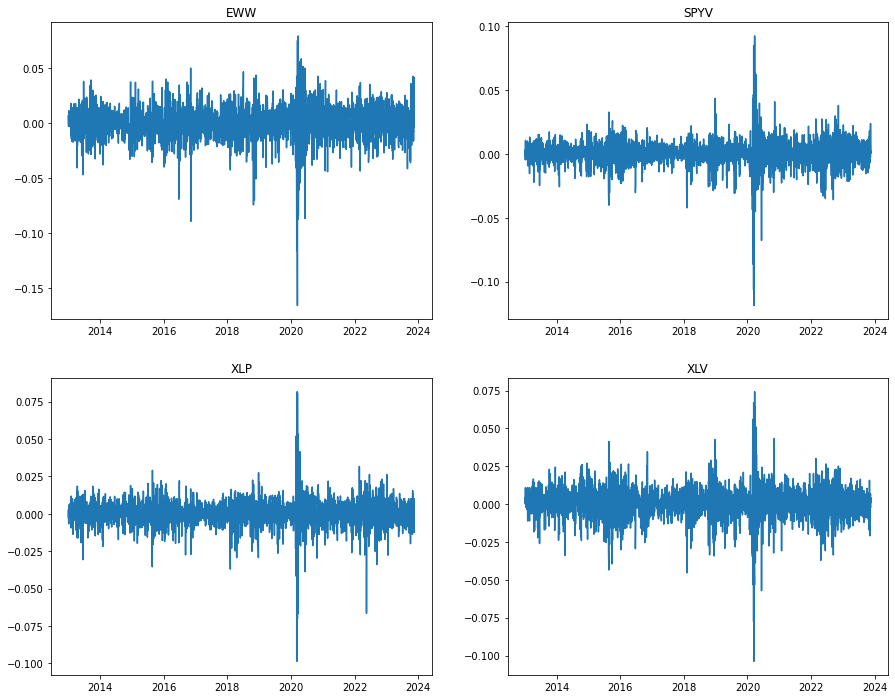

In [175]:
fig, ax1 = plt.subplots(ncols=2, nrows=int(np.ceil(count/2)), figsize=(15, 3*count))  # Set the figure size here
ax = ax1.flatten()

for col, ax in zip(dfret.columns, ax):
    ax.plot(dfret[col])
    ax.set_title(col)

<Axes: >

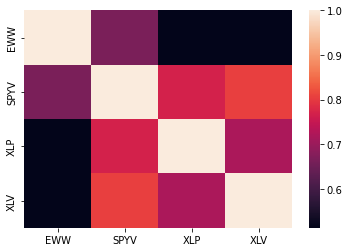

In [176]:
#!pip install seaborn
import seaborn as sns
sns.heatmap(dfret.corr())

In [177]:
dfcumuret = dfret.cumsum().apply(np.exp)
dfcumuret.head()

,EWW,SPYV,XLP,XLV
Date,,,,
2013-01-03,0.998052,1.002850,0.997486,1.001229
2013-01-04,1.005287,1.005158,1.000279,1.005655
2013-01-07,1.003200,1.003122,0.993576,1.008852
2013-01-08,1.000278,0.998507,0.990782,1.009097
2013-01-09,1.011688,0.999593,0.993017,1.020162


<Axes: xlabel='Date'>

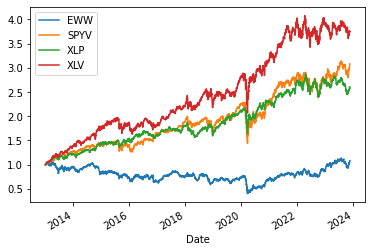

In [178]:
dfcumuret.plot()

<Axes: xlabel='Date'>

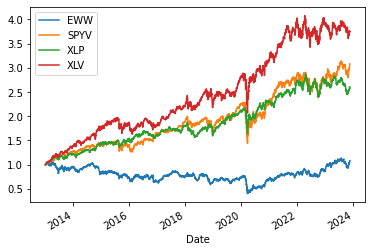

In [134]:
dfcumuret_exTSLA = dfcumuret[tickers]
dfcumuret_exTSLA.plot()

# Find stock weights (w) that minimize portfolio volatility

In [179]:
#!pip install scipy
import scipy
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import minimize

bounds = Bounds(-1,1) # all weights between 0 and 1
linear_constraint = LinearConstraint(np.ones(count), 1,1) # sum of weight >1 and <1, hence sum of weight = 1 (equality constraint)
covar=dfret.cov()
r=np.mean(dfret,axis=0)*252 # r = mean return of each stock

weights = np.ones(count)
x0 = [0.1]*count # initial guess of respective weights

portfstrderr = lambda w: np.sqrt(np.dot(w, np.dot(w,covar))*252)

res1 = minimize(portfstrderr, x0, method='trust-constr', constraints=linear_constraint, bounds=bounds)

# methods?
- <u/>trust-constr</u>
    - equality and inequality constraints
    - (eg) optimize portfolio weights, given that sum of weights equal 1
- <u/>BFGS</u>
    - unconstrained 
    - (eg) minimum of a quadratic function
- <u/>L-BFGS-B</u>
    - bound constraints

In [182]:
def ret(r,w):
    return r.dot(w)

def vol(w,covar):
    return np.sqrt(np.dot(w, np.dot(w,covar))*252)

def sharpe(ret, vol):
    return ret/vol

w_min = res1.x
ret1 = ret(r,w_min)
vol1 = vol(w_min,covar)
sharpe1 = sharpe(ret1, vol1)
print('return = ', round(ret1,2))
print('vol = ', round(vol1,2))
print('sharpe ratio = ', round(sharpe1,2))

return =  0.09
vol =  0.14
sharpe ratio =  0.66


# Maximize sharpe ratio

In [183]:
invSharpe = lambda w: np.sqrt(np.dot(w, np.dot(w,covar))*252)   /    r.dot(w)
res2 = minimize(invSharpe, x0, method='trust-constr', constraints=linear_constraint, bounds=bounds)

In [184]:
w_Sharpe = res2.x
ret2 = ret(r,w_Sharpe)
vol2 = vol(w_Sharpe,covar)
sharpe2 = sharpe(ret2, vol2)
print('return = ', round(ret2,2))
print('vol = ', round(vol2,2))
print('sharpe ratio = ', round(sharpe2,2))

return =  0.17
vol =  0.19
sharpe ratio =  0.89


# Analyse relationship of return, volatility and sharpe ratio

Text(0, 0.5, 'Return')

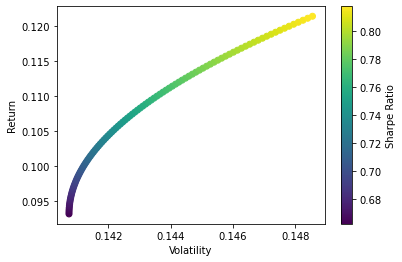

In [140]:
w = w_min
num_ports = 100
r_min = ret(r,w_min)
gap = (max(r) - r_min) / num_ports

all_weights = np.zeros((num_ports, len(dfret.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)

x0= w_min

for i in range(num_ports):
    port_ret = r_min + i*gap 
    double_constraints = LinearConstraint([np.ones(dfret.shape[1]), r], [1,port_ret], [1,port_ret])
    # equality constraint : sum of weight == 1
    # equality constraint : portfolio return == port_ret
    portfvola = lambda w: np.sqrt(np.dot(w,np.dot(w,covar))*252)
    res = minimize(portfvola, x0, method='trust-constr', constraints=double_constraints, bounds=bounds)
    all_weights[i,:] = res.x # populate the weights for diff i
    ret_arr[i] = port_ret
    vol_arr[i] = vol(res.x, covar)
    
sharpe_arr = ret_arr/ vol_arr

plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

In [185]:
df_sharpe = pd.DataFrame({'sharpe':sharpe_arr, 
                          'ret_arr':ret_arr, 'vol_arr':vol_arr})

In [189]:
df_sharpe

,sharpe,ret_arr,vol_arr
0,0.662252,0.093207,0.140742
1,0.664274,0.093492,0.140743
2,0.666288,0.093777,0.140746
3,0.668294,0.094062,0.140750
4,0.670292,0.094347,0.140755
...,...,...,...
95,0.813059,0.120288,0.147945
96,0.814168,0.120573,0.148094
97,0.815266,0.120858,0.148244
98,0.816355,0.121143,0.148395


In [142]:
all_weights_df = pd.DataFrame(all_weights)
all_weights_df.columns = tickers

In [143]:
df_sharpe = df_sharpe.join(all_weights_df, how='left')

In [144]:
df_sharpe = df_sharpe.sort_values('sharpe',ascending=False)

In [145]:
print(tickers)

for i in range(10):
    # 0 - 9
    # 10 - 19
    # 90-99
    ave_sharpe = df_sharpe['sharpe'][i*10:i*10+10].mean()
    print()
    print('average sharpe = ', round(ave_sharpe,2))
    
    ave_weights = []
    for each in tickers:
        ave_weight = df_sharpe[each][i*10:i*10+10].mean()
        ave_weights.append(round(ave_weight,3))
        
    print('ave_weights')
    print(ave_weights)

['EWW', 'SPYV', 'XLP', 'XLV']

average sharpe =  0.81
ave_weights
[np.float64(-0.194), np.float64(0.238), np.float64(0.56), np.float64(0.397)]

average sharpe =  0.8
ave_weights
[np.float64(-0.171), np.float64(0.216), np.float64(0.577), np.float64(0.378)]

average sharpe =  0.79
ave_weights
[np.float64(-0.148), np.float64(0.194), np.float64(0.595), np.float64(0.359)]

average sharpe =  0.77
ave_weights
[np.float64(-0.125), np.float64(0.172), np.float64(0.613), np.float64(0.34)]

average sharpe =  0.76
ave_weights
[np.float64(-0.102), np.float64(0.15), np.float64(0.631), np.float64(0.321)]

average sharpe =  0.74
ave_weights
[np.float64(-0.079), np.float64(0.129), np.float64(0.648), np.float64(0.302)]

average sharpe =  0.73
ave_weights
[np.float64(-0.056), np.float64(0.107), np.float64(0.666), np.float64(0.283)]

average sharpe =  0.71
ave_weights
[np.float64(-0.033), np.float64(0.085), np.float64(0.684), np.float64(0.264)]

average sharpe =  0.69
ave_weights
[np.float64(-0.01), np.flo

In [190]:
weights = [-0.194, 0.238, 0.56, 0.397]

In [191]:
pd.DataFrame({'Tickers':tickers, 'Weights':weights}).sort_values('Weights', ascending=False)

,Tickers,Weights
2,XLP,0.560
3,XLV,0.397
1,SPYV,0.238
0,EWW,-0.194


<font color='red'> Highest sharpe ratio of 1.07 is attained with high weight in MSFT (40%).  The performance of MSFT dominates the portfolio. TSLA, JNJ and WMT have weights of 12%, the rest are less than 10%. 

# Thank you for reading :)